# Предсказание цены на б/у автомобиль в Германии, анализ рынка и проверка статической гипотезы

Целью является предсказание цены по следующим параметрам: год регистрации, кробка передач, мощность двигателя, бренд, модель, пробег, "не бит, не крашен", вид топлива

In [ ]:
# импорт библиотек и загрузка датасета

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv("autos.csv")
df.head(5)

In [ ]:
# копирование датасета только с нужными колонками

df1 = df[['yearOfRegistration', 'gearbox', 'powerPS', 'brand', 'model', 'kilometer', 'notRepairedDamage', 'fuelType', 'price']].copy()
df1.head()


## Очистка данных

удаление строк, в которых неизвестна модель авто

In [39]:
df2 = df1[df1.model != "andere"]
df2.dropna(subset=['model'], how='all', inplace=True)
df2.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


yearOfRegistration    gearbox  powerPS       brand  model  kilometer  \
0                1993    manuell        0  volkswagen   golf     150000   
2                2004  automatik      163        jeep  grand     125000   
3                2001    manuell       75  volkswagen   golf     150000   
4                2008    manuell       69       skoda  fabia      90000   
5                1995    manuell      102         bmw    3er     150000   

  notRepairedDamage fuelType  price  
0               NaN   benzin    480  
2               NaN   diesel   9800  
3              nein   benzin   1500  
4              nein   diesel   3600  
5                ja   benzin    650

удаление строк с нереальными годами и со слишком раритетным авто

In [40]:
df2['yearOfRegistration'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 2017, 1981, 2003, 1994, 1991, 1990,
       2006, 1999, 2012, 2010, 2013, 2000, 1992, 1996, 1985, 1989, 2015,
       1968, 1976, 1983, 1973, 1969, 1987, 1986, 1982, 1988, 1980, 1971,
       1984, 1970, 1979, 1974, 1965, 1978, 1972, 1966, 1977, 1961, 1963,
       1960, 5000, 1954, 1967, 1000, 1500, 2200, 1964, 3000, 2066, 9999,
       1975, 2019, 1959, 9000, 2900, 5900, 1945, 5911, 1400, 4000, 8000,
       1200, 8500, 1962, 3700, 1957, 1234, 1936, 1923, 2290, 1952, 6200,
       7000, 1930, 1938, 1956, 1950, 7500, 1800, 5555, 1300, 1111, 7100,
       2500, 8200, 1958, 1600], dtype=int64)

In [41]:
df2 = df2[df2['yearOfRegistration'].between(1950, 2020)]
df2

yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell        0  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371522                2005    manuell        0  mitsubishi         colt   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  
0          150000               NaN   benzin    480  
2          125000               NaN   diesel   9800  
3          150000              nein   benzin   1500  
4           90000              nein   diesel   3600  
5          150000                ja   benzin    650  
...           ...               ...      ...    ...  
371522     150000                ja   benzin      0  
371524     125000              nein   benzin   1199  
371525     150000              nein   diesel   9200  
371526     150000               NaN   diesel   3400  
371527      50000              nein   benzin  28990  

[324522 rows x 9 columns]

In [42]:
df2.yearOfRegistration.value_counts(dropna = False)

2000    20675
1999    20169
2005    20035
2006    18551
2001    18150
        ...  
1956        3
1954        3
1958        2
1957        1
1952        1
Name: yearOfRegistration, Length: 67, dtype: int64

удаление строк с неясной коробкой передач

In [43]:
df2.gearbox.value_counts(dropna = False)

manuell      242966
automatik     67129
NaN           14427
Name: gearbox, dtype: int64

In [44]:
df2.dropna(subset=['gearbox'], how='all', inplace=True)
df2

yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell        0  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371522                2005    manuell        0  mitsubishi         colt   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  
0          150000               NaN   benzin    480  
2          125000               NaN   diesel   9800  
3          150000              nein   benzin   1500  
4           90000              nein   diesel   3600  
5          150000                ja   benzin    650  
...           ...               ...      ...    ...  
371522     150000                ja   benzin      0  
371524     125000              nein   benzin   1199  
371525     150000              nein   diesel   9200  
371526     150000               NaN   diesel   3400  
371527      50000              nein   benzin  28990  

[310095 rows x 9 columns]

In [45]:
df2.kilometer.value_counts(dropna = False)

150000    202069
125000     32532
100000     13203
90000      10782
80000       9470
70000       8339
60000       7416
50000       6480
40000       5425
30000       5000
20000       4458
5000        3587
10000       1334
Name: kilometer, dtype: int64

In [46]:
# удаление строк с неясным типом топлива

df2.fuelType.value_counts(dropna = False)

benzin     191171
diesel      95215
NaN         18710
lpg          4234
cng           501
hybrid        151
andere         86
elektro        27
Name: fuelType, dtype: int64

In [47]:
df2.dropna(subset=['fuelType'], how='all', inplace=True)
df2 = df2[df.fuelType != "andere"]
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell        0  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371522                2005    manuell        0  mitsubishi         colt   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  
0          150000               NaN   benzin    480  
2          125000               NaN   diesel   9800  
3          150000              nein   benzin   1500  
4           90000              nein   diesel   3600  
5          150000                ja   benzin    650  
...           ...               ...      ...    ...  
371522     150000                ja   benzin      0  
371524     125000              nein   benzin   1199  
371525     150000              nein   diesel   9200  
371526     150000               NaN   diesel   3400  
371527      50000              nein   benzin  28990  

[291299 rows x 9 columns]

Будем рассматирвать машины с отсутствующими данными в колонке notRepairedDamage "не битыми и не крашенными"

In [48]:
df2['notRepairedDamage'] = df2['notRepairedDamage'].fillna("nein")
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell        0  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371522                2005    manuell        0  mitsubishi         colt   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  
0          150000              nein   benzin    480  
2          125000              nein   diesel   9800  
3          150000              nein   benzin   1500  
4           90000              nein   diesel   3600  
5          150000                ja   benzin    650  
...           ...               ...      ...    ...  
371522     150000                ja   benzin      0  
371524     125000              nein   benzin   1199  
371525     150000              nein   diesel   9200  
371526     150000              nein   diesel   3400  
371527      50000              nein   benzin  28990  

[291299 rows x 9 columns]

удаление строк с неясной ценой. Пусть корректная цена лежит в промежутке от 100 евро до 200000 евро

In [49]:
df2.price.value_counts(dropna = False)

0        5459
1500     4030
500      3978
1200     3444
2500     3326
         ... 
20845       1
91900       1
20589       1
40899       1
8188        1
Name: price, Length: 5106, dtype: int64

In [50]:
df2 = df2[df2.price.between(100, 200000)]
df2.dropna(subset=['price'], how='all', inplace=True)
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell        0  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell        0        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  
0          150000              nein   benzin    480  
2          125000              nein   diesel   9800  
3          150000              nein   benzin   1500  
4           90000              nein   diesel   3600  
5          150000                ja   benzin    650  
...           ...               ...      ...    ...  
371521     150000              nein   benzin   1150  
371524     125000              nein   benzin   1199  
371525     150000              nein   diesel   9200  
371526     150000              nein   diesel   3400  
371527      50000              nein   benzin  28990  

[284776 rows x 9 columns]

заполнение неясных или неправдоподобных данных по мощности модой для данной модели. Пусть интервал корректных мощностей лежит в промежутке от 30 л.с. до 500 л.с

In [51]:
df2.powerPS.value_counts(dropna = False)

75      19117
0       17318
60      12789
150     12746
140     12107
        ...  
1597        1
572         1
4507        1
1433        1
244         1
Name: powerPS, Length: 644, dtype: int64

In [52]:
dp = df2.groupby(['model'])['powerPS'].agg(lambda x:x.value_counts().index[0])
df2['powerPS'] = df2.apply(lambda x: x['powerPS'] if x['powerPS'] in range(30, 501) else dp.loc[x['model']], axis = 1)
df2 = df2[df2.powerPS != 0]
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell       75  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell      125        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  
0          150000              nein   benzin    480  
2          125000              nein   diesel   9800  
3          150000              nein   benzin   1500  
4           90000              nein   diesel   3600  
5          150000                ja   benzin    650  
...           ...               ...      ...    ...  
371521     150000              nein   benzin   1150  
371524     125000              nein   benzin   1199  
371525     150000              nein   diesel   9200  
371526     150000              nein   diesel   3400  
371527      50000              nein   benzin  28990  

[284684 rows x 9 columns]

In [53]:
df2[df2.model == 'zafira'].powerPS.value_counts()

125    727
101    409
150    349
120    239
140    184
116    147
147    121
105     61
97      44
110     43
100     35
94      32
165     31
115     31
200     22
192     21
82      19
241     11
102      8
74       5
122      5
145      5
92       4
130      4
103      3
90       3
118      3
81       3
75       3
126      3
143      3
128      3
149      3
124      2
108      2
80       2
146      2
131      2
96       2
85       2
112      1
104      1
88       1
154      1
132      1
136      1
144      1
239      1
156      1
160      1
170      1
300      1
107      1
117      1
119      1
129      1
141      1
155      1
193      1
62       1
Name: powerPS, dtype: int64

проверка наличия всех брендов

In [54]:
df2.brand.value_counts(dropna = False)

volkswagen       65081
bmw              34405
opel             31237
mercedes_benz    27943
audi             26943
ford             19817
renault          13625
peugeot           8060
fiat              6185
seat              5885
skoda             4878
mazda             3880
smart             3851
nissan            3559
toyota            3365
mini              3069
citroen           2769
volvo             2383
hyundai           2080
honda             2043
mitsubishi        1822
kia               1759
porsche           1600
alfa_romeo        1461
suzuki            1025
chrysler           846
dacia              788
land_rover         689
chevrolet          639
subaru             572
jeep               548
daihatsu           528
daewoo             342
lancia             289
jaguar             268
trabant            193
saab               127
lada               118
rover               12
Name: brand, dtype: int64

In [55]:
df3 = df2.copy()

In [56]:
df3['age'] = 2020 - df['yearOfRegistration']
df3

yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell       75  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell      125        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  age  
0          150000              nein   benzin    480   27  
2          125000              nein   diesel   9800   16  
3          150000              nein   benzin   1500   19  
4           90000              nein   diesel   3600   12  
5          150000                ja   benzin    650   25  
...           ...               ...      ...    ...  ...  
371521     150000              nein   benzin   1150   20  
371524     125000              nein   benzin   1199   20  
371525     150000              nein   diesel   9200   24  
371526     150000              nein   diesel   3400   18  
371527      50000              nein   benzin  28990    7  

[284684 rows x 10 columns]

добавление свойства, которое показывает соотношение цены к среднему годовому пробегу. Этот показатель позволит объективнее посмотреть на цену и отбросить строки с неправдоподобными ценами

In [57]:
df3['priceInd'] = df3.price/(df3.kilometer/df3.age)
df3

yearOfRegistration    gearbox  powerPS       brand        model  \
0                     1993    manuell       75  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell      125        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  age  priceInd  
0          150000              nein   benzin    480   27  0.086400  
2          125000              nein   diesel   9800   16  1.254400  
3          150000              nein   benzin   1500   19  0.190000  
4           90000              nein   diesel   3600   12  0.480000  
5          150000                ja   benzin    650   25  0.108333  
...           ...               ...      ...    ...  ...       ...  
371521     150000              nein   benzin   1150   20  0.153333  
371524     125000              nein   benzin   1199   20  0.191840  
371525     150000              nein   diesel   9200   24  1.472000  
371526     150000              nein   diesel   3400   18  0.408000  
371527      50000              nein   benzin  28990    7  4.058600  

[284684 rows x 11 columns]

In [58]:
df3.priceInd.describe()

count    284684.000000
mean          1.128055
std           8.015089
min           0.002000
25%           0.190000
50%           0.420000
75%           0.932900
max        1813.000000
Name: priceInd, dtype: float64

оставим только те машины, чьи показатели цены от годового пробега лежат в промежутке ± 1σ

In [59]:
df4 = df3[df3.priceInd.between(np.mean(df3.priceInd) - np.std(df3.priceInd), np.mean(df3.priceInd) + np.std(df3.priceInd))]
df4.index.name = 'id'
df4

yearOfRegistration    gearbox  powerPS       brand        model  \
id                                                                        
0                     1993    manuell       75  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell      125        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  age  priceInd  
id                                                                  
0          150000              nein   benzin    480   27  0.086400  
2          125000              nein   diesel   9800   16  1.254400  
3          150000              nein   benzin   1500   19  0.190000  
4           90000              nein   diesel   3600   12  0.480000  
5          150000                ja   benzin    650   25  0.108333  
...           ...               ...      ...    ...  ...       ...  
371521     150000              nein   benzin   1150   20  0.153333  
371524     125000              nein   benzin   1199   20  0.191840  
371525     150000              nein   diesel   9200   24  1.472000  
371526     150000              nein   diesel   3400   18  0.408000  
371527      50000              nein   benzin  28990    7  4.058600  

[281022 rows x 11 columns]

получим dummies для модели и типа топлива. Брэнд не будет участвовать в качестве свойства, так как модель уже подразумевает разделение марок авто. Для коробки передач и "битости-крашенности" создадим колонку из 1 и 0 при помощи функции

In [60]:
fd = pd.get_dummies(df4.fuelType)
fd

benzin  cng  diesel  elektro  hybrid  lpg
id                                               
0            1    0       0        0       0    0
2            0    0       1        0       0    0
3            1    0       0        0       0    0
4            0    0       1        0       0    0
5            1    0       0        0       0    0
...        ...  ...     ...      ...     ...  ...
371521       1    0       0        0       0    0
371524       1    0       0        0       0    0
371525       0    0       1        0       0    0
371526       0    0       1        0       0    0
371527       1    0       0        0       0    0

[281022 rows x 6 columns]

In [61]:
md = pd.get_dummies(df4.model)
md

100  145  147  156  159  1_reihe  1er  200  2_reihe  300c  ...  \
id                                                                 ...   
0         0    0    0    0    0        0    0    0        0     0  ...   
2         0    0    0    0    0        0    0    0        0     0  ...   
3         0    0    0    0    0        0    0    0        0     0  ...   
4         0    0    0    0    0        0    0    0        0     0  ...   
5         0    0    0    0    0        0    0    0        0     0  ...   
...     ...  ...  ...  ...  ...      ...  ...  ...      ...   ...  ...   
371521    0    0    0    0    0        0    0    0        0     0  ...   
371524    0    0    0    0    0        0    0    0        0     0  ...   
371525    0    0    0    0    0        0    0    0        0     0  ...   
371526    0    0    0    0    0        0    0    0        0     0  ...   
371527    0    0    0    0    0        0    0    0        0     0  ...   

        wrangler  x_reihe  x_trail  x_type  xc_reihe  yaris  yeti  ypsilon  \
id                                                                           
0              0        0        0       0         0      0     0        0   
2              0        0        0       0         0      0     0        0   
3              0        0        0       0         0      0     0        0   
4              0        0        0       0         0      0     0        0   
5              0        0        0       0         0      0     0        0   
...          ...      ...      ...     ...       ...    ...   ...      ...   
371521         0        0        0       0         0      0     0        0   
371524         0        0        0       0         0      0     0        0   
371525         0        0        0       0         0      0     0        0   
371526         0        0        0       0         0      0     0        0   
371527         0        0        0       0         0      0     0        0   

        z_reihe  zafira  
id                       
0             0       0  
2             0       0  
3             0       0  
4             0       0  
5             0       0  
...         ...     ...  
371521        0       1  
371524        0       0  
371525        0       0  
371526        0       0  
371527        0       0  

[281022 rows x 248 columns]

In [62]:
def gbCode(x):
    t = 1
    if x == 'manuell':
        t = 0    
    return t

gbc = df4.gearbox.apply(gbCode)
gbc

id
0         0
2         1
3         0
4         0
5         0
         ..
371521    0
371524    1
371525    0
371526    0
371527    0
Name: gearbox, Length: 281022, dtype: int64

In [63]:
def nrdCode(x):
    t = 1
    if x == 'nein':
        t = 0    
    return t

nrdc = df4.notRepairedDamage.apply(nrdCode)
nrdc

id
0         0
2         0
3         0
4         0
5         1
         ..
371521    0
371524    0
371525    0
371526    0
371527    0
Name: notRepairedDamage, Length: 281022, dtype: int64

In [64]:
X2 = pd.concat([nrdc, gbc], axis = 1)
X2.columns = ["nrd", "gb"]
X2

nrd  gb
id             
0         0   0
2         0   1
3         0   0
4         0   0
5         1   0
...     ...  ..
371521    0   0
371524    0   1
371525    0   0
371526    0   0
371527    0   0

[281022 rows x 2 columns]

In [65]:
X1 = pd.concat([md.drop('100', axis = 1), fd.drop('lpg', axis = 1)], axis = 1)
X1

145  147  156  159  1_reihe  1er  200  2_reihe  300c  3_reihe  ...  \
id                                                                     ...   
0         0    0    0    0        0    0    0        0     0        0  ...   
2         0    0    0    0        0    0    0        0     0        0  ...   
3         0    0    0    0        0    0    0        0     0        0  ...   
4         0    0    0    0        0    0    0        0     0        0  ...   
5         0    0    0    0        0    0    0        0     0        0  ...   
...     ...  ...  ...  ...      ...  ...  ...      ...   ...      ...  ...   
371521    0    0    0    0        0    0    0        0     0        0  ...   
371524    0    0    0    0        0    0    0        0     0        0  ...   
371525    0    0    0    0        0    0    0        0     0        0  ...   
371526    0    0    0    0        0    0    0        0     0        0  ...   
371527    0    0    0    0        0    0    0        0     0        0  ...   

        yaris  yeti  ypsilon  z_reihe  zafira  benzin  cng  diesel  elektro  \
id                                                                            
0           0     0        0        0       0       1    0       0        0   
2           0     0        0        0       0       0    0       1        0   
3           0     0        0        0       0       1    0       0        0   
4           0     0        0        0       0       0    0       1        0   
5           0     0        0        0       0       1    0       0        0   
...       ...   ...      ...      ...     ...     ...  ...     ...      ...   
371521      0     0        0        0       1       1    0       0        0   
371524      0     0        0        0       0       1    0       0        0   
371525      0     0        0        0       0       0    0       1        0   
371526      0     0        0        0       0       0    0       1        0   
371527      0     0        0        0       0       1    0       0        0   

        hybrid  
id              
0            0  
2            0  
3            0  
4            0  
5            0  
...        ...  
371521       0  
371524       0  
371525       0  
371526       0  
371527       0  

[281022 rows x 252 columns]

In [66]:
X0 = pd.concat([df4[['powerPS', 'kilometer', 'age']], X1], axis = 1)
X0

powerPS  kilometer  age  145  147  156  159  1_reihe  1er  200  ...  \
id                                                                      ...   
0            75     150000   27    0    0    0    0        0    0    0  ...   
2           163     125000   16    0    0    0    0        0    0    0  ...   
3            75     150000   19    0    0    0    0        0    0    0  ...   
4            69      90000   12    0    0    0    0        0    0    0  ...   
5           102     150000   25    0    0    0    0        0    0    0  ...   
...         ...        ...  ...  ...  ...  ...  ...      ...  ...  ...  ...   
371521      125     150000   20    0    0    0    0        0    0    0  ...   
371524      101     125000   20    0    0    0    0        0    0    0  ...   
371525      102     150000   24    0    0    0    0        0    0    0  ...   
371526      100     150000   18    0    0    0    0        0    0    0  ...   
371527      320      50000    7    0    0    0    0        0    0    0  ...   

        yaris  yeti  ypsilon  z_reihe  zafira  benzin  cng  diesel  elektro  \
id                                                                            
0           0     0        0        0       0       1    0       0        0   
2           0     0        0        0       0       0    0       1        0   
3           0     0        0        0       0       1    0       0        0   
4           0     0        0        0       0       0    0       1        0   
5           0     0        0        0       0       1    0       0        0   
...       ...   ...      ...      ...     ...     ...  ...     ...      ...   
371521      0     0        0        0       1       1    0       0        0   
371524      0     0        0        0       0       1    0       0        0   
371525      0     0        0        0       0       0    0       1        0   
371526      0     0        0        0       0       0    0       1        0   
371527      0     0        0        0       0       1    0       0        0   

        hybrid  
id              
0            0  
2            0  
3            0  
4            0  
5            0  
...        ...  
371521       0  
371524       0  
371525       0  
371526       0  
371527       0  

[281022 rows x 255 columns]

In [67]:
X = pd.concat([X0, X2], axis = 1)
X

powerPS  kilometer  age  145  147  156  159  1_reihe  1er  200  ...  \
id                                                                      ...   
0            75     150000   27    0    0    0    0        0    0    0  ...   
2           163     125000   16    0    0    0    0        0    0    0  ...   
3            75     150000   19    0    0    0    0        0    0    0  ...   
4            69      90000   12    0    0    0    0        0    0    0  ...   
5           102     150000   25    0    0    0    0        0    0    0  ...   
...         ...        ...  ...  ...  ...  ...  ...      ...  ...  ...  ...   
371521      125     150000   20    0    0    0    0        0    0    0  ...   
371524      101     125000   20    0    0    0    0        0    0    0  ...   
371525      102     150000   24    0    0    0    0        0    0    0  ...   
371526      100     150000   18    0    0    0    0        0    0    0  ...   
371527      320      50000    7    0    0    0    0        0    0    0  ...   

        ypsilon  z_reihe  zafira  benzin  cng  diesel  elektro  hybrid  nrd  \
id                                                                            
0             0        0       0       1    0       0        0       0    0   
2             0        0       0       0    0       1        0       0    0   
3             0        0       0       1    0       0        0       0    0   
4             0        0       0       0    0       1        0       0    0   
5             0        0       0       1    0       0        0       0    1   
...         ...      ...     ...     ...  ...     ...      ...     ...  ...   
371521        0        0       1       1    0       0        0       0    0   
371524        0        0       0       1    0       0        0       0    0   
371525        0        0       0       0    0       1        0       0    0   
371526        0        0       0       0    0       1        0       0    0   
371527        0        0       0       1    0       0        0       0    0   

        gb  
id          
0        0  
2        1  
3        0  
4        0  
5        0  
...     ..  
371521   0  
371524   1  
371525   0  
371526   0  
371527   0  

[281022 rows x 257 columns]

In [68]:
y = df4.price
y

id
0           480
2          9800
3          1500
4          3600
5           650
          ...  
371521     1150
371524     1199
371525     9200
371526     3400
371527    28990
Name: price, Length: 281022, dtype: int64

Для обчения модели будет использоваться RandomForestRegressor. При помощи RandomizedSearchCV найдём лучшие параметры

In [70]:
rfr = RandomForestRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
param_space = {"bootstrap": [True],
        "max_depth": [6, 10, 12],
        "min_samples_leaf": [3, 4],
        "min_samples_split": [3, 5],
        "n_estimators": [50, 100, 300]
}
rfr_optim = RandomizedSearchCV(rfr, param_space, n_iter=12, cv=5,
                                        n_jobs=-1, random_state=42)

rfr_optim.fit(X_train, y_train)

    

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [71]:
rfr_optim.best_params_

{'n_estimators': 300,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 12,
 'bootstrap': True}

In [75]:
rfr_optim.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [72]:
rfr_model = RandomForestRegressor(bootstrap = True, max_depth = 12, min_samples_leaf = 3, min_samples_split = 3, n_estimators = 300)

убедимся, что модель не переобучена или недообучена

In [73]:
model_train = rfr_model.fit(X_train, y_train)
model_test = rfr_model.fit(X_test, y_test)
model_train.score(X_train, y_train)

In [87]:
model_test.score(X_test, y_test)

0.8994606417267217

In [82]:
def price_pred(pwr, km, age, mdl, fuel, nrd, grb):
    mdl_index = np.where(X.columns == mdl)[0][0]
    fuel_index = np.where(X.columns == fuel)[0][0]
    
        
    x = np.zeros(len(X.columns))
    x[0] = pwr
    x[1] = km
    x[2] = age
    x[-1] = grb
    x[-2] = nrd
    if mdl_index >= 0:
        x[mdl_index] = 1
    if fuel_index >= 0:
        x[fuel_index] = 1 
    return rfr_model.predict([x])[0]
    

Предсказание цены на VW Golf с двигателем мощностью в 100л.с., пробегом 125000 км, возрастом 8 лет, бензиновым двс, не битый, не крашенный и с АКПП

In [83]:
price_pred(100, 125000, 8, 'golf', 'benzin', 0, 1)

9675.870887486015

вывод схожего запроса, чтобы убедиться, что цена лежит в разумном пределе

In [93]:
df4[(df4.model == 'golf') & (df4.gearbox == 'automatik') & (df4.age <= 10 ) & (df4.kilometer.between(100000, 150000))]

yearOfRegistration    gearbox  powerPS       brand model  kilometer  \
id                                                                            
1090                  2011  automatik      160  volkswagen  golf     125000   
2914                  2017  automatik      101  volkswagen  golf     150000   
3134                  2011  automatik      140  volkswagen  golf     125000   
3380                  2016  automatik       70  volkswagen  golf     150000   
6239                  2018  automatik      105  volkswagen  golf     150000   
...                    ...        ...      ...         ...   ...        ...   
367899                2016  automatik      200  volkswagen  golf     125000   
369284                2016  automatik       70  volkswagen  golf     150000   
369867                2010  automatik      211  volkswagen  golf     150000   
370808                2010  automatik      140  volkswagen  golf     125000   
371049                2010  automatik      105  volkswagen  golf     125000   

       notRepairedDamage fuelType  price  age  priceInd  
id                                                       
1090                nein   benzin  12950    9  0.932400  
2914                nein   benzin   1500    3  0.030000  
3134                nein   diesel  14900    9  1.072800  
3380                nein   benzin    299    4  0.007973  
6239                nein   diesel   6250    2  0.083333  
...                  ...      ...    ...  ...       ...  
367899              nein   benzin  12990    4  0.415680  
369284              nein   benzin    300    4  0.008000  
369867              nein   benzin  15500   10  1.033333  
370808              nein   diesel  12500   10  1.000000  
371049              nein   diesel  10950   10  0.876000  

[321 rows x 11 columns]

определение ценого индекса для каждого бренда

In [41]:
df5 = pd.DataFrame(df4.groupby('brand')['priceInd'].agg('mean'))
df5

priceInd
brand                  
alfa_romeo     0.499155
audi           1.069701
bmw            1.014405
chevrolet      0.875522
chrysler       0.626180
citroen        0.599270
dacia          1.000126
daewoo         0.190007
daihatsu       0.326936
fiat           0.547862
ford           0.537899
honda          0.609979
hyundai        1.121195
jaguar         0.645416
jeep           1.514846
kia            1.010696
lada           0.985377
lancia         0.435794
land_rover     1.867239
mazda          0.722407
mercedes_benz  1.084105
mini           1.626195
mitsubishi     0.526123
nissan         0.656161
opel           0.446331
peugeot        0.516371
porsche        3.558994
renault        0.380894
rover          1.220306
saab           0.655088
seat           0.672833
skoda          0.922865
smart          0.740554
subaru         0.698331
suzuki         0.936298
toyota         0.782817
trabant        1.848894
volkswagen     0.776893
volvo          0.656639

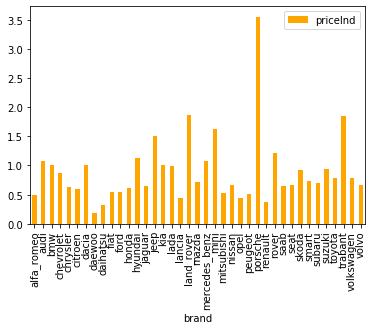

In [42]:
df5.plot.bar(y='priceInd', rot=90, color = 'orange')

из графика следует, что самые дорогие машины - Porsche, Land Rover и Trabant(по всей видимости, эти машины являются коллекционными) самые бюджетные - Daewoo, Daihatsu и Renault

In [43]:
df6 = pd.DataFrame(df4.groupby('brand')['price'].agg('count')).sort_values('price', ascending = True)
df6['share'] = df6.price*100/df6.price.sum()
df6

price      share
brand                          
rover             12   0.004270
lada             116   0.041278
saab             127   0.045192
trabant          174   0.061917
jaguar           267   0.095010
lancia           287   0.102127
daewoo           342   0.121699
daihatsu         526   0.187174
jeep             530   0.188597
subaru           568   0.202119
chevrolet        632   0.224893
land_rover       638   0.227028
dacia            781   0.277914
chrysler         842   0.299621
suzuki          1013   0.360470
porsche         1063   0.378262
alfa_romeo      1439   0.512060
kia             1742   0.619880
mitsubishi      1810   0.644078
honda           2025   0.720584
hyundai         2054   0.730904
volvo           2371   0.843706
citroen         2757   0.981062
mini            3000   1.067532
toyota          3350   1.192077
nissan          3533   1.257197
smart           3830   1.362883
mazda           3843   1.367509
skoda           4814   1.713033
seat            5842   2.078841
fiat            6127   2.180256
peugeot         8029   2.857072
renault        13592   4.836632
ford           19611   6.978457
audi           26487   9.425241
mercedes_benz  27480   9.778594
opel           31124  11.075289
bmw            33907  12.065603
volkswagen     64337  22.893937

In [44]:
df6['brand_sh'] = df6.share.apply(lambda x: x if x > 1.5 else df6[df6['share'] < 5].share.sum())
df7 = pd.DataFrame(df6.brand_sh.round(2).drop_duplicates())
df7.rename(index={'rover':'other'},inplace=True)
df7

brand_sh
brand                  
other             27.78
skoda              1.71
seat               2.08
fiat               2.18
peugeot            2.86
renault            4.84
ford               6.98
audi               9.43
mercedes_benz      9.78
opel              11.08
bmw               12.07
volkswagen        22.89

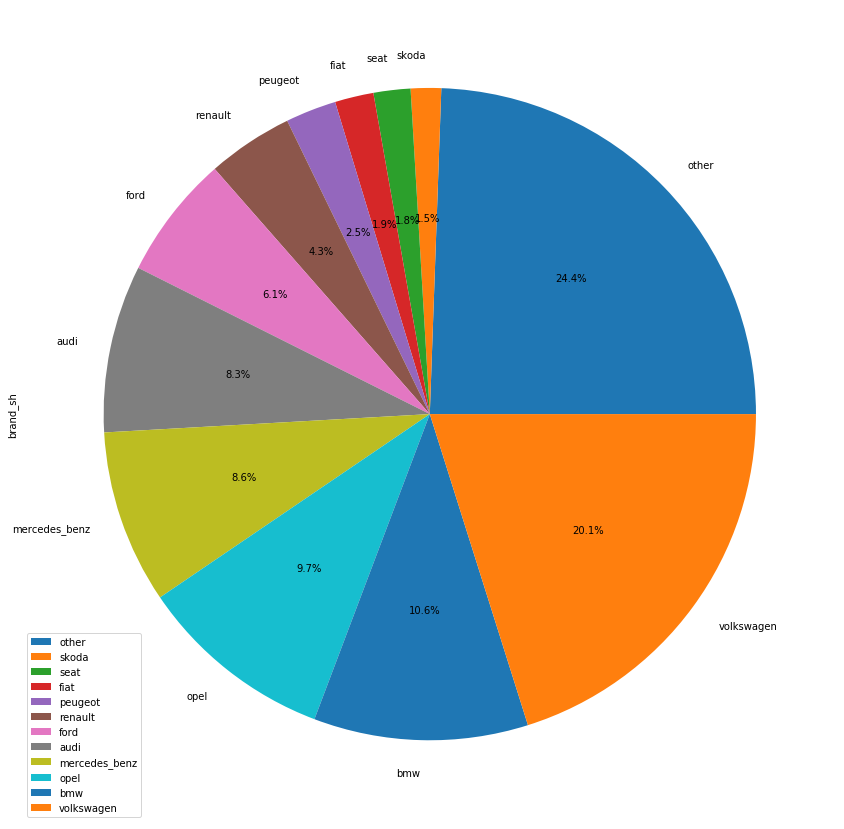

In [45]:
df7.plot.pie(y='brand_sh', figsize=(15, 15),  autopct='%1.1f%%')

на этой диаграмме видно, что Volkswagen оправдано носит своё имя народного автомобиля, обходя ближайшего конкурента почти в 2 раза

# Проверка статистических гипотез

проверим есть ли корреляция между распределеием цен на автомобили и распределением зарплат в Германии. Данные за 2016 год взяты отсюда https://www.iwd.de/artikel/mittelschicht-oder-reich-441648/ 

In [36]:
inc = pd.read_csv("income.csv")
inc.head(20)

range  Gesamtbevölkerung
0   weniger als 400 Euro                0.9
1            401 bis 800                5.9
2           801 bis 1200               12.9
3          1201 bis 1600               18.0
4          1601 bis 2000               17.8
5          2001 bis 2400               14.7
6          2401 bis 2800               10.0
7          2801 bis 3200                7.1
8          3201 bis 3600                4.1
9          3601 bis 4000                2.5
10         4001 bis 4400                1.8
11         4401 bis 4800                1.3
12         4801 bis 5200                0.7
13         5201 bis 5600                0.6
14         5601 bis 6000                0.5
15         6001 bis 7000                0.6
16    mehr als 7000 Euro                0.8

где range диапазон зарплат и Gesamtbevölkerung процент населения 

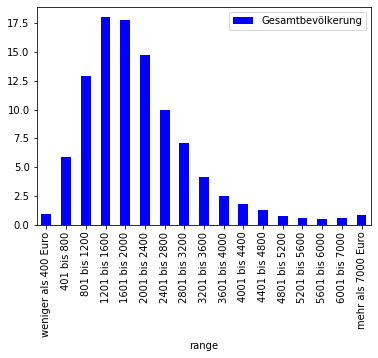

In [37]:
inc.plot.bar(x= 'range', y='Gesamtbevölkerung', rot=90, color = 'blue')

In [38]:
df4

yearOfRegistration    gearbox  powerPS       brand        model  \
id                                                                        
0                     1993    manuell       75  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell      125        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  age  priceInd  
id                                                                  
0          150000              nein   benzin    480   27  0.086400  
2          125000              nein   diesel   9800   16  1.254400  
3          150000              nein   benzin   1500   19  0.190000  
4           90000              nein   diesel   3600   12  0.480000  
5          150000                ja   benzin    650   25  0.108333  
...           ...               ...      ...    ...  ...       ...  
371521     150000              nein   benzin   1150   20  0.153333  
371524     125000              nein   benzin   1199   20  0.191840  
371525     150000              nein   diesel   9200   24  1.472000  
371526     150000              nein   diesel   3400   18  0.408000  
371527      50000              nein   benzin  28990    7  4.058600  

[281022 rows x 11 columns]

Разобьём автомобили на 17 сегментов (так же как и в таблице с доходами). Шагом будет медиана цены

In [287]:
step = df4.price.median() 
df4['segment'] = (df4.price//step).apply(lambda x: 16 if x>15 else x )
df4

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


yearOfRegistration    gearbox  powerPS       brand        model  \
id                                                                        
0                     1993    manuell       75  volkswagen         golf   
2                     2004  automatik      163        jeep        grand   
3                     2001    manuell       75  volkswagen         golf   
4                     2008    manuell       69       skoda        fabia   
5                     1995    manuell      102         bmw          3er   
...                    ...        ...      ...         ...          ...   
371521                2000    manuell      125        opel       zafira   
371524                2000  automatik      101       smart       fortwo   
371525                1996    manuell      102  volkswagen  transporter   
371526                2002    manuell      100  volkswagen         golf   
371527                2013    manuell      320         bmw      m_reihe   

        kilometer notRepairedDamage fuelType  price  age  priceInd  segment  
id                                                                           
0          150000              nein   benzin    480   27  0.086400        0  
2          125000              nein   diesel   9800   16  1.254400        2  
3          150000              nein   benzin   1500   19  0.190000        0  
4           90000              nein   diesel   3600   12  0.480000        1  
5          150000                ja   benzin    650   25  0.108333        0  
...           ...               ...      ...    ...  ...       ...      ...  
371521     150000              nein   benzin   1150   20  0.153333        0  
371524     125000              nein   benzin   1199   20  0.191840        0  
371525     150000              nein   diesel   9200   24  1.472000        2  
371526     150000              nein   diesel   3400   18  0.408000        0  
371527      50000              nein   benzin  28990    7  4.058600        8  

[281022 rows x 12 columns]

In [288]:
sales = df4.groupby('segment')['price'].agg('sum')
sales

segment
0     215565595
1     293808258
2     279058245
3     209359025
4     189477592
5     126159727
6      96094784
7      71653939
8      49311780
9      27499400
10     22570972
11     13523439
12      9107110
13      6235613
14      4534974
15      2887483
16      5789032
Name: price, dtype: int64

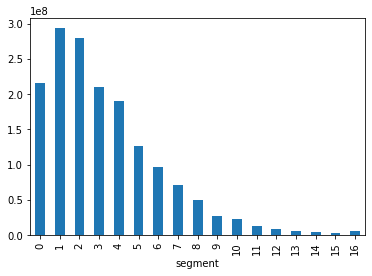

In [289]:
sales.plot.bar()

Изобразим полученные результаты на одном графике

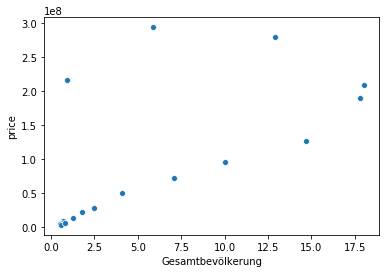

In [299]:
sns.scatterplot(x = inc.Gesamtbevölkerung, y = sales)

Если игнорировать 3 значения в левом верхнем углу, то проглядываетя линейная зависимость между данными.
Проверим гипотезу, найдя коэффициент корреляции Пирсона

In [298]:
corr, p = pearsonr(inc.Gesamtbevölkerung, sales)
print(p)
print(corr)


0.005134923561301861
0.6454720212428651


р значение не превышает уровень значимости (0,05), а следовательно у нас есть основания отвергнуть нулевую гипотезу, утверждающую, что связи нет. Но так как всё таки имеются выбросы, нужно использовать коэффициент корреляции Спирмена, но для этого вначале приведём данные к рангам

In [291]:
inc_Rank = inc.Gesamtbevölkerung.rank()
inc_Rank

0      6.0
1     11.0
2     14.0
3     17.0
4     16.0
5     15.0
6     13.0
7     12.0
8     10.0
9      9.0
10     8.0
11     7.0
12     4.0
13     2.5
14     1.0
15     2.5
16     5.0
Name: Gesamtbevölkerung, dtype: float64

In [292]:
sales_Rank = sales.rank()
sales_Rank

segment
0     15.0
1     17.0
2     16.0
3     14.0
4     13.0
5     12.0
6     11.0
7     10.0
8      9.0
9      8.0
10     7.0
11     6.0
12     5.0
13     4.0
14     2.0
15     1.0
16     3.0
Name: price, dtype: float64

In [296]:
corr, p = spearmanr(inc_Rank, sales_Rank)
print(p)
print(corr)


0.00015653318745556983
0.7909259610463494


р значение получилось ещё меньше, чего, собственно, и следовало ожидать. Коэффициент корреляции равный 0,791 показывет, что между данными существует достаточно явная связь